In [49]:
%matplotlib inline

import os
import datetime
import time
import json

import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error,r2_score

In [2]:
## daily prices

def preprbd(x_db):
    x_db.columns = [x.lower() for x in x_db.columns.values]
    x_db.drop(['date_text','month','month day','day','year'],axis=1,inplace=True)
    x_db.drop(['open','high','low','market cap'],axis=1,inplace=True)


bit_price_d = pd.read_excel("bitcoin_data/btc_close_daily.xlsx")
preprbd(bit_price_d)
bit_price_d.rename(columns={'close':'btc_close'},inplace=True)

eth_price_d = pd.read_excel("bitcoin_data/eth_close_daily.xlsx")
preprbd(eth_price_d)
eth_price_d.rename(columns={'close':'eth_close'},inplace=True)

eth_price_d.head()

,date,eth_close,volume
0,2018-04-01,379.61,1256930000
1,2018-03-31,396.46,1323920000
2,2018-03-30,394.65,1878130000
3,2018-03-29,385.97,1970230000
4,2018-03-28,446.28,1514180000


In [3]:
## minute prices
##

bit_price = pd.read_csv('bitcoin_data/bitstampUSD_1-min_data_2012-01-01_to_2018-03-27.csv')
bit_price.columns = [x.lower() for x in bit_price.columns.values]
bit_price['date_time'] = bit_price['timestamp'].map(lambda x: datetime.datetime.fromtimestamp(x)) ## MSC timezone
bit_price.head()

,timestamp,open,high,low,close,volume_(btc),volume_(currency),weighted_price,date_time
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 10:52:00
1,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 10:53:00
2,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 10:54:00
3,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 10:55:00
4,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 10:56:00


#### Graphs

Bitcoin price evalution 

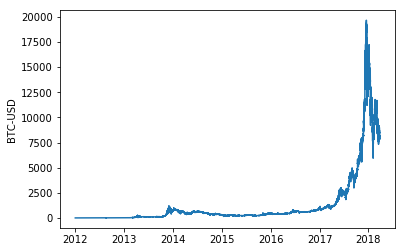

In [5]:
fig, ax = plt.subplots()
ax.plot(bit_price['date_time'],bit_price['open'])
ax.set_ylabel('BTC-USD')

plt.show()

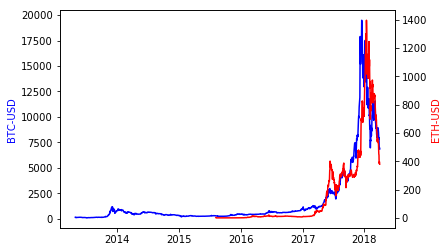

In [6]:
fig, ax1 = plt.subplots()

ax1.plot(bit_price_d['date'],bit_price_d['btc_close'],'b')
ax1.set_ylabel('BTC-USD',color='b')


ax2 = ax1.twinx()
ax2.plot(eth_price_d['date'],eth_price_d['eth_close'],'r')
ax2.set_ylabel('ETH-USD', color='r')
plt.show()

#### Reading news

In [8]:
%%time

def clean_text(text):
    text = re.sub("<.*?>.*?</.*?>","",text)
    text = re.sub("&amp;","&",text)
    text = re.sub("\n"," ",text)

    return text
    

## Loading text
DIR_FILE = "news_coindesk"
cd_news = []
for i_file in os.listdir(DIR_FILE):
    
    # read file
    tt = open (DIR_FILE + "/"+i_file)
    
    # process headline
    news_headline = tt.readline()
    news_headline = re.sub("\n","",news_headline)
    
    # now time for time
    news_time = tt.readline()
    news_time = datetime.datetime.strptime(news_time[0:10],"%Y-%m-%d")
    
    # news text and brief
    news_text = "".join(tt.readlines())
    try:
        news_brief = re.search("<brief>(.*?)</brief>",news_text).group(1)
    except:
        news_brief = ""
    news_text = clean_text(news_text)
    cd_news.append([news_time,news_headline,news_text])
    
    
print ("text loaded")

cd_news = pd.DataFrame(cd_news)
cd_news.columns = ['date','headline','text']

## aggregate text and headlines on daily level
def compute_metrics(x):
    result = {'headline': " ".join(x['headline']), 'text': " ".join(x['text']),'count_news':len(x)}
    return pd.Series(result, name='metrics')

cd_news = cd_news.groupby('date').apply(compute_metrics)


cd_news.reset_index(inplace=True)
cd_news.sort_values('date',inplace=True)

print ("metrics computed")

cd_news.head()

text loaded
metrics computed
Wall time: 2min 25s


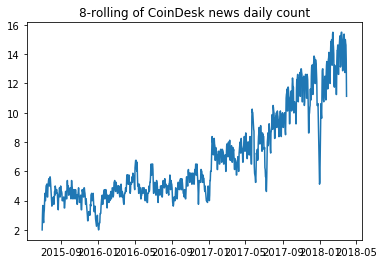

In [9]:
## Plot news count

fig, axs = plt.subplots()

aa = cd_news.rolling(8,min_periods=1)['count_news'].mean()
axs.plot(cd_news['date'],aa)
axs.title.set_text("8-rolling of CoinDesk news daily count")
plt.show()

In [193]:
## Do Tfidf vectorizer
##

tfidf = TfidfVectorizer(ngram_range=(1,2),stop_words='english')
tfidif_vectors = tfidf.fit_transform(cd_news['headline'])
tfidf_col_names = tfidf.vocabulary_.keys()

tfidif_vectors

<997x41109 sparse matrix of type '<class 'numpy.float64'>'
	with 87727 stored elements in Compressed Sparse Row format>

In [194]:
## preparing data for model
pd_tfidif_dense = pd.DataFrame(tfidif_vectors.todense())
pd_tfidif_dense.columns = tfidf_col_names
pd_tfidif_dense['date'] = cd_news['date']

all_data = bit_price_d[['date','btc_close']].merge(pd_tfidif_dense,how='left',on='date')
all_data.fillna(0,inplace=True)

## SORT DATES IN DECREASING ORDER !!!
all_data.sort_values('date',ascending=True,inplace=True,)
all_data.reset_index(inplace=True)
all_data.drop('level_0',axis=1,inplace=True)

## make returns
price = all_data['btc_close']
price_l1 = all_data['btc_close'].shift(1)

all_data['btc_return'] = (price - price_l1)/price_l1 * 100
##all_data['btc_return'] = np.log(price / price_l1)

all_data.dropna(inplace=True)

date_start = '2018-01-01'

dates_train = all_data.query("date<'" + date_start +"'")['date']
X_train = all_data.query("date<'" + date_start +"'").drop(['btc_close','btc_return','date'],axis=1)
y_train = all_data.query("date<'" + date_start +"'")['btc_return']

dates_test = all_data.query("date>='" + date_start +"'")['date']
X_test = all_data.query("date>='" + date_start +"'").drop(['btc_close','btc_return','date'],axis=1)
y_test = all_data.query("date>='" + date_start +"'")['btc_return']

In [122]:
all_data

,date,btc_close,details,million,bitstamp,hack,revealed,singapore,central,bank,...,danske,ushering,designs,koreans,scrapped,enquiries,colored,shutting,piloting,btc_return
1,2013-04-29,144.54,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,7.696893
2,2013-04-30,139.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-3.832849
3,2013-05-01,116.99,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-15.834532
4,2013-05-02,105.21,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-10.069237
5,2013-05-03,97.75,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-7.090581
6,2013-05-04,112.50,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,15.089514
7,2013-05-05,115.91,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3.031111
8,2013-05-06,112.30,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-3.114485
9,2013-05-07,111.50,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.712378
10,2013-05-08,113.57,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.856502


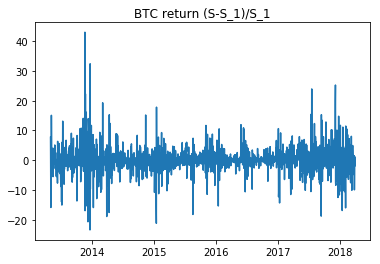

In [127]:
fig, ax = plt.subplots()
ax.plot(all_data['date'],all_data['btc_return'])
ax.set_title("BTC return (S-S_1)/S_1")

32.961723191
-13.415395438
12.1039180751
-1.36675395937


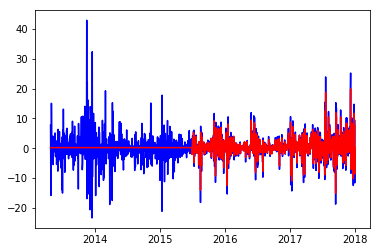

In [168]:
mm = Ridge(alpha=0.2, fit_intercept=True, normalize=False)
mm.fit(X_train,y_train)

y_pred = mm.predict(X_test)

print (mean_squared_error(y_pred,y_test))
print (r2_score(y_pred,y_test))


y_pred = mm.predict(X_train)

print (mean_squared_error(y_pred,y_train))
print (r2_score(y_pred,y_train))

fig,axs = plt.subplots()
axs.plot(dates_train,y_train,'b')
axs.plot(dates_train,y_pred,'r')
plt.show()

In [186]:
ind = np.argsort(np.abs(mm.coef_))
ind = ind[::-1]

for i_ind in ind[0:20]:
    feat = X_train.columns.values[i_ind]
    print (feat,mm.coef_[i_ind])


euroclear -10.1728566788
slow 8.71144542924
inches -6.73031189705
tycoon -6.20474899871
bruised 6.15158447738
abuzz 5.97690442051
frenzy 5.96370445542
stance 5.93035614781
disclose 5.85815490694
shenzhen 5.82395604017
bullies 5.76208679656
guide 5.71779903235
staff -5.64990528993
geo 5.61304926946
infrastructure 5.56314049463
accredited 5.53819465643
gpu 5.47399390661
offs 5.4257677016
entrance -5.40445703335
marshals -5.32038793364


32.961723191
-13.415395438


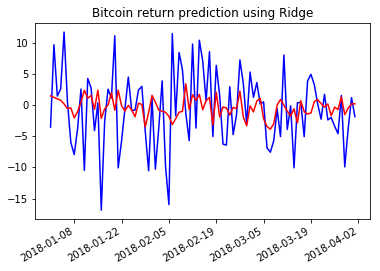

In [192]:
y_pred = mm.predict(X_test)

print (mean_squared_error(y_pred,y_test))
print (r2_score(y_pred,y_test))

fig,axs = plt.subplots()
axs.plot(dates_test,y_test,'b')
axs.plot(dates_test,y_pred,'r')
axs.set_title('Bitcoin return prediction using Ridge')
fig.autofmt_xdate()

plt.show()